Look at distances

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import seaborn as sns
from compress_pickle import load, dump
from statistics import mean, median
from c_means_clustering import network_c_means
from copy import deepcopy
import itertools as it
import matplotlib.pyplot as plt
from math import log10
from ease import EASE


plt.style.use('bmh')

def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

path = './files/'

regulome_network_edges = pd.read_csv(filepath_or_buffer=path+'/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_graph = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids=False)
proteins = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).unique()

clusters_dict = open_pickle("c_means_leiden_clusters.gz")
clusters_dict = {cluster_id: cluster for (cluster_id, cluster) in clusters_dict.items() if len(cluster) > 10}

msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')
results_99 = open_pickle("c_means_6iter_edge_99.gz")
results_98 = open_pickle("c_means_6iter_edge.gz")

In [5]:
protein_edges = pd.concat([regulome_network_edges['ProteinAid'], regulome_network_edges['ProteinBid']]).value_counts()
most_connected_proteins = tuple(protein_edges.index[:5])
least_connected_proteins = tuple(protein_edges.index[-5:])

In [ ]:
from itertools import combinations

iter1_clusters = results_99[0][3]
clusters = [cluster for cluster in iter1_clusters.values() if len(clusters) if len(cluster) < 2000]
print(len(clusters))

overlap_coefficients = list()

for set_A, set_B in combinations(clusters, 2):
    ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
    overlap_coefficients.append(ov_coeff)

fig, ax = plt.subplots(1,1,figsize=[8,4], sharex=True)
title = fig.suptitle(f"Overlap coefficient of c-means clusters after 1 iteration (percentile = 99)", fontsize=15, y=1)

sns.histplot(overlap_coefficients, ax=ax)
ax.set_xlabel("Overlap Coefficient")
# ax.set_ylim([0, 2000])


plt.savefig('./images/c_means_overlap_coeff_edge_99_2.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])

In [ ]:
gene_sets = pd.Series([set(gene_set) for gene_set in msigdb_c3_tft_dict.values()])  # some gene sets have no mapping aka have 0 genes
overlap_coefficients = list()

for set_A, set_B in combinations(gene_sets, 2):
    if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
        continue
    ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
    overlap_coefficients.append(ov_coeff)

fig, ax = plt.subplots(1,1,figsize=[8,4], sharex=True)
title = fig.suptitle(f"Overlap coefficient of MSigDB c3 tft gene sets", fontsize=15, y=1)

sns.histplot(overlap_coefficients, ax=ax)
ax.set_xlabel("Overlap Coefficient")
ax.set_ylim([0, 10000])

plt.savefig('./images/c_means_overlap_coeff_tft.png', dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[title])

In [13]:
def enrichment_ease(clusters, gene_set):

    enrichment_dict = dict()
    for (clusterid, cluster) in clusters.items():

        enrichment = EASE(query_set=cluster, genesets=gene_set, PT= regulome_graph.vcount())
        enrichment_dict[clusterid] = (enrichment, len(cluster), cluster) # maybe save this as a namedtuple with enrihcment and subgraph
    return enrichment_dict

threshold = 0.01

def calculate_CCS(enrichment_dict, threshold=0.05):
    enrichments = list()
    for cluster in enrichment_dict.values():
        cluster = cluster[0]
        enriched = cluster[cluster['FDR'] < threshold]
        if enriched.empty:
            continue
        enrichments.append(enriched[:][['pathway_id', 'FDR']])
    n_enriched_clusters = len(enrichments)
    enriched_df = pd.concat(enrichments)
    avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
    avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    CCS = avg_set_per_cluster / avg_cluster_per_set

    return CCS, n_enriched_clusters, avg_set_per_cluster, avg_cluster_per_set

In [2]:
def leiden_clustering(graph, res, n_iter, beta=0.01):
    return graph.community_leiden(objective_function='modularity',
                            weights='PPV',
                            resolution=res,
                            beta=beta,
                            n_iterations=n_iter)

leiden_clusters = leiden_clustering(regulome_graph, 11, 10)
clusters_dict = {n : set(regulome_graph.vs[node]['name'] for node in cluster) for (n, cluster) in enumerate(leiden_clusters) if len(cluster) > 15}

In [3]:
from c_means_clustering import network_c_means

results = network_c_means(regulome_graph, deepcopy(clusters_dict), 2, n_iter=10, optimize=True, percentile=99, distance_measure='edge_ratio', path_lengths=None, cores=6)

Iteration 1 of 10


100%|██████████| 15041/15041 [00:11<00:00, 1258.83it/s]


Updating Clusters: percentile 99
Iteration 2 of 10


100%|██████████| 15041/15041 [00:19<00:00, 789.77it/s] 


Updating Clusters: percentile 99
Iteration 3 of 10


100%|██████████| 15041/15041 [00:18<00:00, 818.97it/s] 


Updating Clusters: percentile 99
Iteration 4 of 10


100%|██████████| 15041/15041 [00:17<00:00, 878.69it/s] 


Updating Clusters: percentile 99
Iteration 5 of 10


100%|██████████| 15041/15041 [00:17<00:00, 845.76it/s] 


Updating Clusters: percentile 99
Iteration 6 of 10


100%|██████████| 15041/15041 [00:17<00:00, 847.10it/s] 


Updating Clusters: percentile 99
Iteration 7 of 10


100%|██████████| 15041/15041 [00:16<00:00, 920.17it/s] 


Updating Clusters: percentile 99
Iteration 8 of 10


100%|██████████| 15041/15041 [00:16<00:00, 895.59it/s] 


Updating Clusters: percentile 99
Iteration 9 of 10


100%|██████████| 15041/15041 [00:16<00:00, 938.94it/s] 


Updating Clusters: percentile 99
Iteration 10 of 10


100%|██████████| 15041/15041 [00:14<00:00, 1012.16it/s]


Updating Clusters: percentile 99


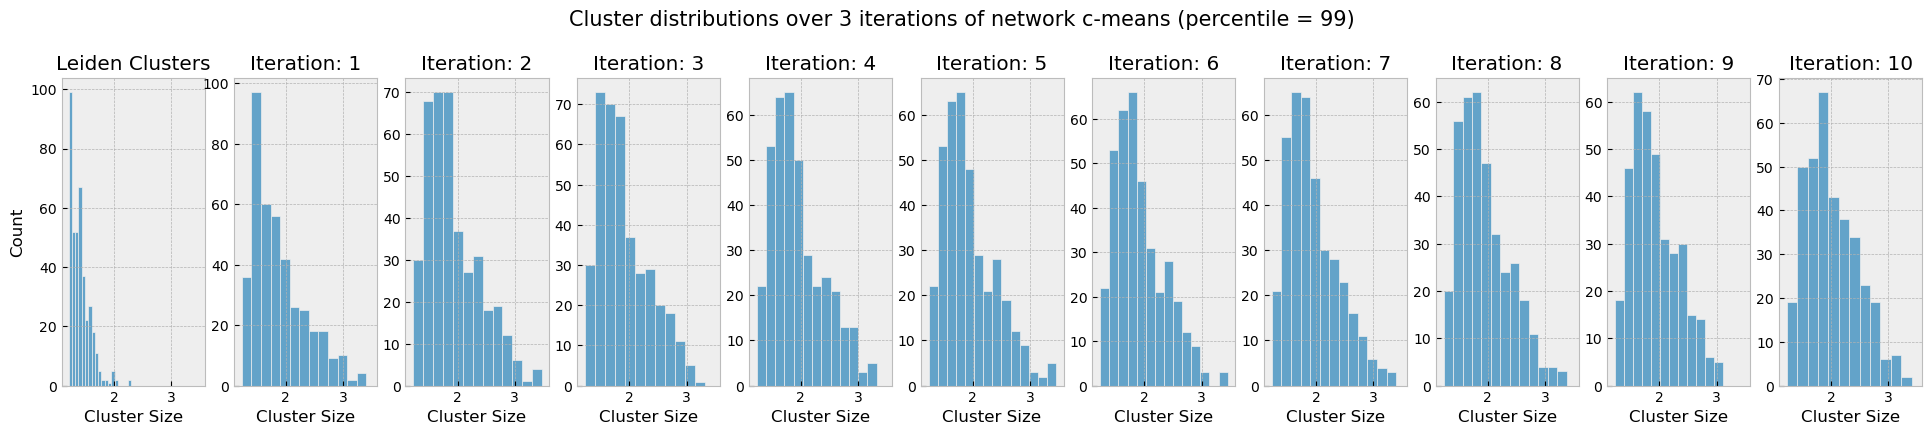

In [14]:
from math import log10
cluster_history = results[0][:]
fig, axes = plt.subplots(1,len(cluster_history),figsize=[24,4], sharex=True)
title = fig.suptitle(f"Cluster distributions over 3 iterations of network c-means (percentile = 99)", fontsize=15, y=1.05)

for iter, (ax, clusters) in enumerate(zip(axes, cluster_history)):
    result_sizes = [log10(len(cluster)) for cluster in clusters.values()]
    sns.histplot(result_sizes, ax=ax)
    ax.set_title(f"Iteration: {iter}")
    ax.set_xlabel("Cluster Size")
    # ax.set_xlim((0, 1000))
    if iter != 0:
        ax.set(ylabel=None)
    else:
        ax.set_title(f"Leiden Clusters")


In [15]:
CCS_df = pd.DataFrame()


for iteration, clusters in enumerate(results[0][:]):
    clusters = {cluster_id: cluster  for cluster_id, cluster in clusters.items() if len(cluster) < 2000}
    enrichment = enrichment_ease(clusters, msigdb_c3_tft_dict)
    
    CCS_values = calculate_CCS(enrichment)
    CCS_df = pd.concat([CCS_df, pd.DataFrame({'iter': [iteration], 'n_enriched':[CCS_values[1]], 'avg_s/c': [CCS_values[2]], 'avg_c/s':[CCS_values[3]], 'CCS': [CCS_values[0]]})])

In [16]:
CCS_df

,iter,n_enriched,avg_s/c,avg_c/s,CCS
0,0,50,4.140000,1.352941,3.060000
0,1,161,16.161491,4.646429,3.478261
0,2,147,13.959184,4.728111,2.952381
0,3,146,13.787671,4.659722,2.958904
0,4,147,13.721088,4.319058,3.176871
0,5,143,13.216783,3.225256,4.097902
0,6,141,11.666667,4.122807,2.829787
0,7,145,15.917241,4.346516,3.662069
0,8,139,12.482014,3.375486,3.697842
0,9,139,13.280576,3.489603,3.805755
